<a href="https://ai4life-mdc24.grand-challenge.org/ai4life-mdc24/">
    <img src="https://rumc-gcorg-p-public.s3.amazonaws.com/b/756/denoising.x10.jpeg" height="200" />
</a>

# SUPPORT dataset

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import tifffile
import pooch
import numpy as np

from careamics import CAREamist
from careamics.config import create_n2v_configuration

# use n2v2
use_n2v2 = False

# folder in which to save all the data
root = Path("support")

## Import the dataset

In [2]:
# download the data using pooch
data_root = root / "data"
dataset_url = "https://zenodo.org/records/10925939/files/noisy.tiff?download=1"

file = pooch.retrieve(
    url=dataset_url,
    known_hash="c09a0748a67a9364f257e0aff9502a283b8794f35381577f5dfea6ac1bd01e03",
    path=data_root,
)

SHA256 hash of downloaded file: c09a0748a67a9364f257e0aff9502a283b8794f35381577f5dfea6ac1bd01e03
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


## Visualize data

Image shape: (1001, 1024, 1024)


Text(0.5, 1.0, 'Slice 900')

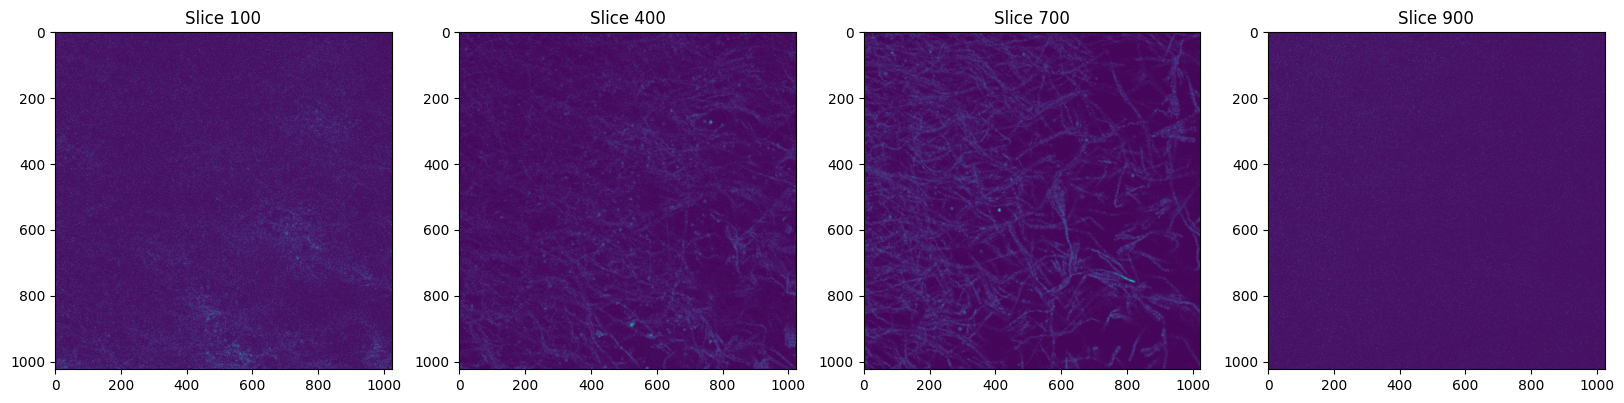

In [5]:
# load training and validation image and show them side by side
train_image = tifffile.imread(file)
print(f"Image shape: {train_image.shape}")

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(train_image[100])
ax[0].set_title("Slice 100")
ax[1].imshow(train_image[400])
ax[1].set_title("Slice 400")
ax[2].imshow(train_image[700])
ax[2].set_title("Slice 700")
ax[3].imshow(train_image[900])
ax[3].set_title("Slice 900")

## Train with CAREamics

### Create configuration


In [6]:
# create configuration
algo = "n2v2" if use_n2v2 else "n2v"

config = create_n2v_configuration(
    experiment_name="support_"+algo,
    data_type="array",
    axes="ZYX",
    patch_size=(16, 64, 64),
    batch_size=2,
    num_epochs=20,
    use_n2v2=use_n2v2,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 3,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'ZYX',
                 'batch_size': 2,
                 'data_type': 'array',
                 'patch_size': [16, 64, 64],
                 'transforms': [{'flip_x': True,
 

### Train

In [7]:
# instantiate a CAREamist
careamist = CAREamist(
    source=config,
    work_dir=root / algo,
)

# train
careamist.train(
    train_source=train_image,
    val_percentage=0.,
    val_minimum_split=10, # use 10 patches as validation
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 8443/8443 [02:51<00:00, 49.18it/s, train_loss_step=1.19, val_loss=0.732, train_loss_epoch=0.617]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 8443/8443 [02:51<00:00, 49.16it/s, train_loss_step=1.19, val_loss=0.732, train_loss_epoch=0.617]


## Predict 

In [8]:
prediction = careamist.predict(
    source=train_image, 
    tile_size=(32, 128, 128),
    tile_overlap=(8, 48, 48),
    batch_size=1,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Save predictions

In [24]:
pred_folder = root / ("results_" + algo)
pred_folder.mkdir(exist_ok=True, parents=True)

tifffile.imwrite(pred_folder / "prediction.tiff", prediction[0])

### Visualize the prediction

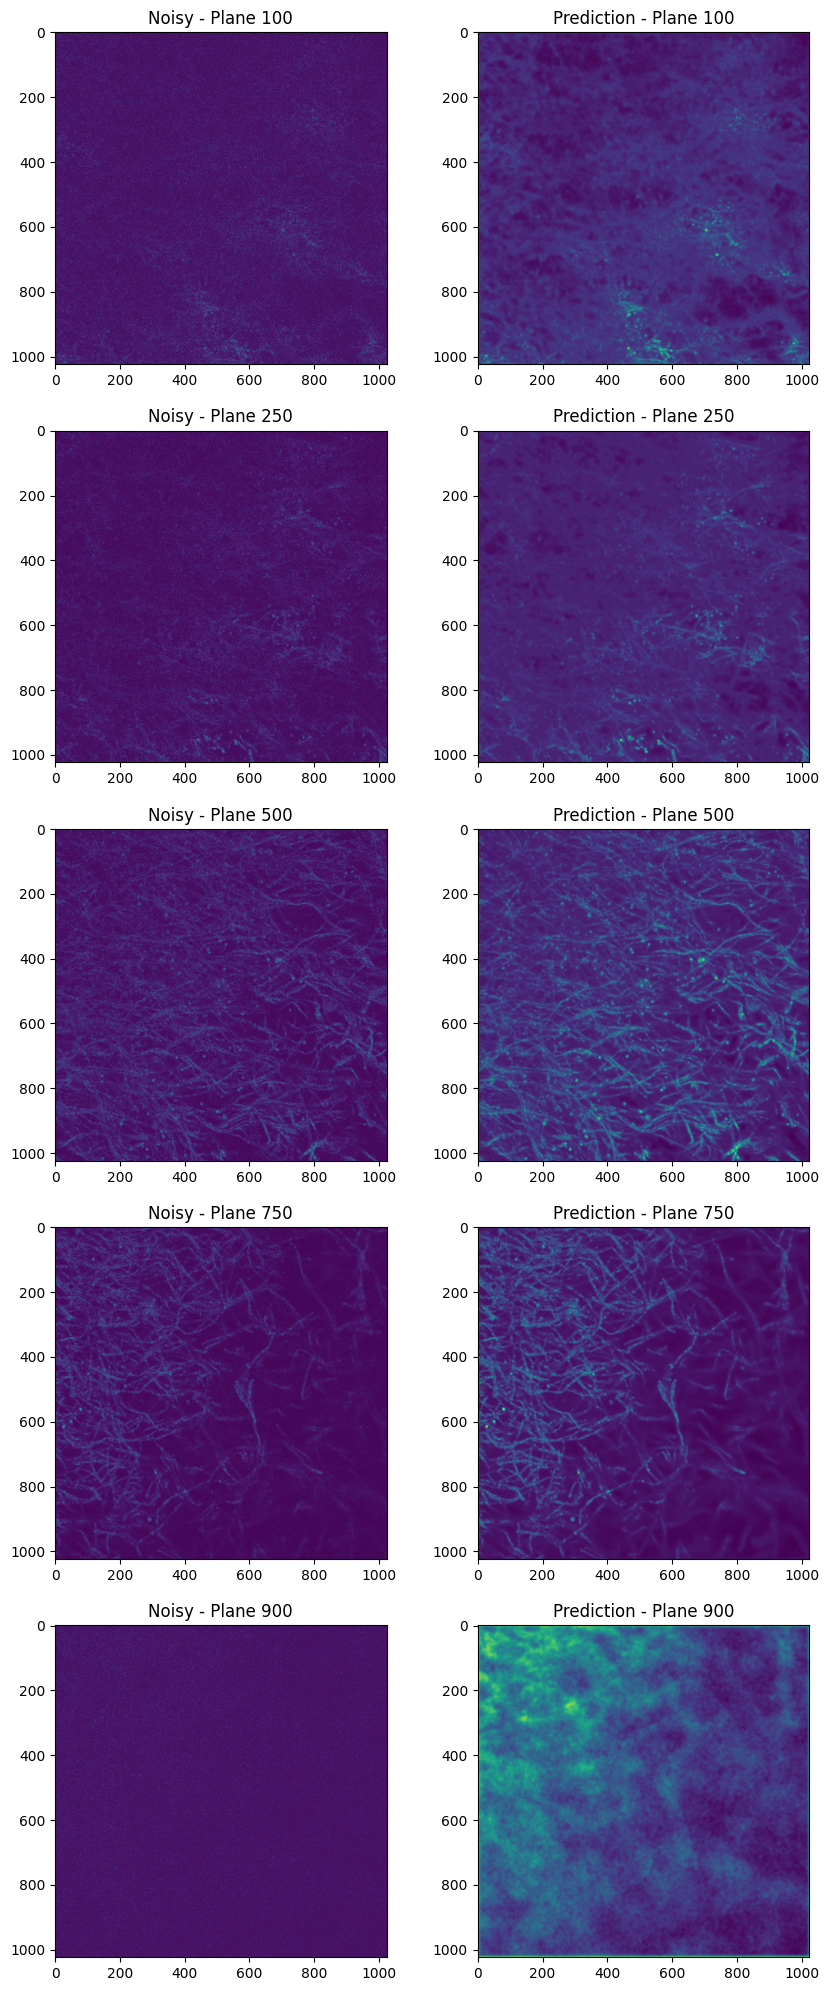

In [11]:
zs = [100, 250, 500, 750, 900]

fig, ax = plt.subplots(len((zs)), 2, figsize=(10, 5*len(zs)))
for i, z in enumerate(zs):
    ax[i, 0].imshow(train_image[z])
    ax[i, 0].set_title(f"Noisy - Plane {z}")

    ax[i, 1].imshow(prediction[0].squeeze()[z])
    ax[i, 1].set_title(f"Prediction - Plane {z}")
